# monte carlo code for policyII

In [1]:
import numpy as np
import random
from random import sample
import math 
from collections import defaultdict
import itertools 

In [2]:
weibull_scale=(2365.08,996.88,713.55,1406.84,343.76,3933.12,828.19,2040.95)
weibull_shape=(414.16,109.25,79.81,115.21,169.81,143.60,43.83,296.48)
tf=(2,6.5,2.5,6,5,3.5,3,3.5)
tp=(0.4,5.42,0.625,0.857,1.25,0.7,0.429,0.875)
time_interval=5
running_time=100000

In [3]:
def reset():
    st= [0]*16
    return tuple(st)

In [4]:
def env(action,st,i): 
    
    f = random.weibullvariate(weibull_scale[i],weibull_shape[i])
    
    if action == 0 : #Do nothing
        if f <= st[i]: # fail
            st[i]=0 #replace
            reward= -(time_interval / tp[i])*time_interval * math.ceil(tf[i]/time_interval)
            st[i+8]=0
        else:
            st[i] +=5
            reward = 5
            
    if action ==1 : #PM action
        reward = -(time_interval / tp[i])*tp[i]    
        st[i]=0
        st[i+8]=0
            
           
    return (tuple(st) , reward)

# pi function 

In [5]:
ALL_POSSIBLE_ACTIONS = [0,1]
def policy_using_pi(St, pi):
    return np.random.choice(ALL_POSSIBLE_ACTIONS, p=[pi[(St,a)] for a in ALL_POSSIBLE_ACTIONS])

In [6]:
def choose_action(state , pi,i):
    st = (state[i],state[i+8])
    return policy_using_pi(st, pi)  #epsilon_soft 

# Episode functions

In [7]:
#GAMMA = 0.50
def play_episode(pi,i,GAMMA):
    #S0,A0,R1,S1,A1,R2,S2,A2,R3 ,...
    s= reset()
    a= choose_action(s, pi ,i)
    
    #r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [((s, a, 0))]
    
    for j in range(running_time//time_interval +1):
    
        s , r = env(a,list(s),i)
        if (j == running_time//time_interval):
            states_actions_rewards.append((s, None, r))
        else:
            a= choose_action(s, pi ,i)
            states_actions_rewards.append((s,a, r))
            
    
     # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        
       # the value of the terminal state is 0 by definition
       # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    
    return states_actions_returns


# Run all episodes

# for tire

In [20]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 0 

for epi in range(1500 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.5)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))
                  

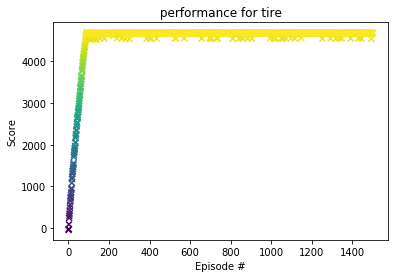

In [23]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y) 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for tire ')
plt.show()

In [22]:
i=0
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    current_state = obs
np.unique(time_replace)

array([2350])

# for transmission

In [31]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 1  

for epi in range(1000 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.5)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))
        

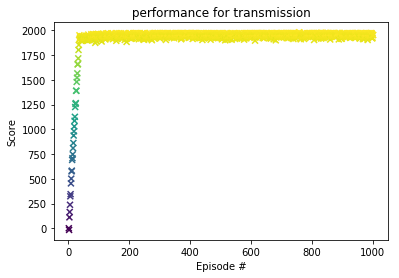

In [32]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y) 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for transmission ')
plt.show()

In [34]:
i=1
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print(current_state[i] ,action,r,obs[i])
    current_state = obs
np.unique(time_replace)

array([985])

# for wheel Rim

In [32]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 2 

for epi in range(600 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.5)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))

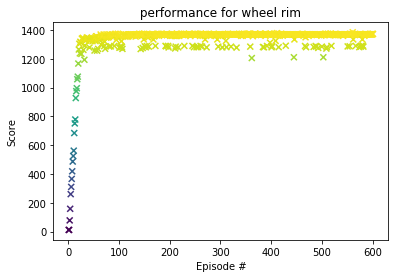

In [33]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for wheel rim ')
plt.show()

In [36]:
i=2
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print (current_state[i] ,action,r,obs[i] )
    current_state = obs
np.unique(time_replace)

array([695])

# for coupling

In [39]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 3 

for epi in range(300 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.50)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))

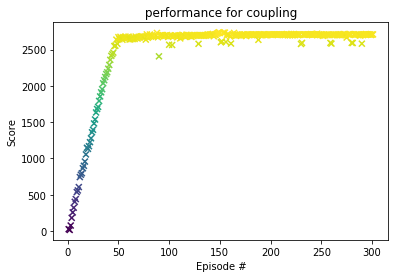

In [42]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for coupling ')
plt.show()

In [41]:
i=3
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print (current_state[i] ,action,r,obs[i] )
    current_state = obs
np.unique(time_replace)

array([1365])

# for motor

In [30]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 4

for epi in range(800 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.5)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))

In [54]:
i=4
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print (current_state[i] ,action,r,obs[i] )
    current_state = obs
np.unique(time_replace)

array([340])

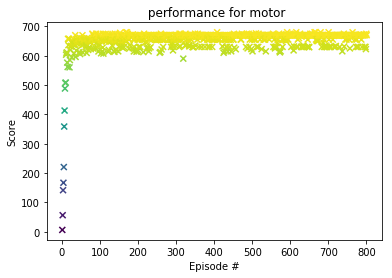

In [31]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for motor')
plt.show()

# for brake

In [54]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 5

for epi in range(200 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.5)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))

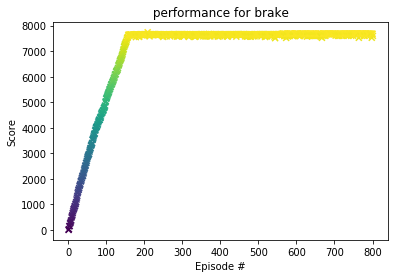

In [56]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y) 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for brake ')
plt.show()

In [53]:
i=5
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print (current_state[i] ,action,r,obs[i] )
    current_state = obs
np.unique(time_replace)

array([3830])

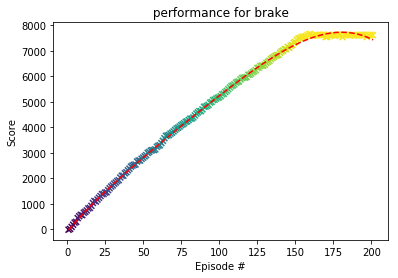

In [54]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
fit = np.polyfit(x, y, deg=4)
p = np.poly1d(fit) 
plt.plot(x,p(x),"r--") 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for brake ')
plt.show()

# for steering wheel

In [35]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 6

for epi in range(1500 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.5)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))

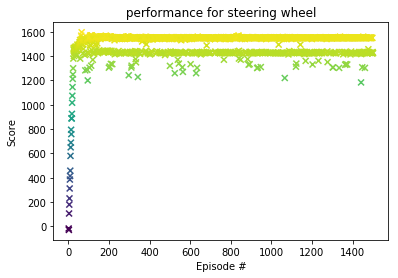

In [36]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y) 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for steering wheel ')
plt.show()

In [37]:
i=6
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print (current_state[i] ,action,r,obs[i] )
    current_state = obs
np.unique(time_replace)

array([785])

# for shifting gears

In [52]:
pi = defaultdict(lambda: 1/len(ALL_POSSIBLE_ACTIONS))
Q = np.zeros((100000 ,2) + (2,))
returns =np.zeros((100000 ,2) + (2,))
N = np.zeros((100000 ,2) + (2,))
scores = []
i = 7

for epi in range(1000 +1):# Looping through episodes 
    
    epsilon = 1/(epi+1)
    # generate an episode using pi
    states_actions_returns = play_episode(pi,i,0.50)
    rewards = []
    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        s_t = (s[i] ,s[i+8])
        state_action = (s_t,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s_t][a] += G
            N[s_t][a] +=1
                
            Q[s_t][a] = returns[s_t][a] /N[s_t][a] # Average reward across episodes
            
            seen_state_action_pairs.add(state_action)
            rewards.append(G)  
            #for each s in the episode         
            A_star = np.argmax(Q[s_t])# Finding the action with maximum value        
            for a in ALL_POSSIBLE_ACTIONS: # Update action probability for s_t in policy
                if a == A_star:
                    pi[(s_t,a)] = 1 - epsilon + (epsilon / len(ALL_POSSIBLE_ACTIONS))
                else:
                    pi[(s_t,a)] = (epsilon / len(ALL_POSSIBLE_ACTIONS))
                    
    scores.append(sum(rewards))

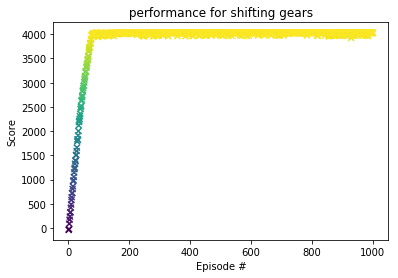

In [53]:
import matplotlib.pyplot as plt
# Plot the policy performance
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.scatter(x, y, marker='x', c=y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(' performance for shifting gears ')
plt.show()

In [55]:
i=7
time_replace = []
current_state = reset()
for j in range(50000):
    
    action = np.argmax(Q[(current_state[i],current_state[i+8])])
    if action ==1:
        time_replace.append(current_state[i])
    obs , r = env(action,list(current_state),i)
    #print (current_state[i] ,action,r,obs[i] )
    current_state = obs
np.unique(time_replace)

array([2000])